# **Прогнозирование температуры звезды**

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

-   Закон смещения Вина.
-   Закон Стефана-Больцмана.
-   Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**

-   Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
-   Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
-   Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
-   Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
-   Тип звезды.
    
    Тип звезды
    
    Номер, соответствующий типу
    
    Коричневый карлик
    
    0
    
    Красный карлик
    
    1
    
    Белый карлик
    
    2
    
    Звёзды главной последовательности
    
    3
    
    Сверхгигант
    
    4
    
    Гипергигант
    
    5
    
-   Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.
    

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

💡 Справочная информация: Светимость Солнца (англ. _Average Luminosity of Sun_) �0=3.828⋅1026ВтL0​=3.828⋅1026Вт Радиус Солнца (англ. _Average Radius of Sun_) �0=6.9551⋅108мR0​=6.9551⋅108м

**Алгоритм решения задачи**

**Шаг 1.**  Загрузка исходных данных из файла

Скопировать кодPYTHON

```
/datasets/6_class.csv 
```

**Шаг 2.**  Исследовательский анализ

Проведите исследовательский анализ:

-   количественных данных,
-   категориальных данных.

Обязательно используйте графический анализ и сделайте вывод.

**Шаг 3.**  Подготовка данных к построению модели

1.  По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
2.  Если необходимо, категоризируйте исходные данные.
3.  Подготовьте обучающую и тестовую выборки.
4.  Проведите масштабирование количественных данных.

**Шаг 4.**  Построение простой модели нейронной сети — baseline

1.  Создайте класс для задания архитектуры нейронной сети.
2.  Самостоятельно выберите количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Попробуйте и сравните несколько подобных комбинаций.
3.  Проведите обучение нейронной сети:
    -   Создайте функцию для обучения нейронной сети.
    -   Проведите обучение модели.
    -   Постройте график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

![image](https://pictures.s3.yandex.net/resources/Untitled_79_1651780526.png)

-   Сделайте вывод.

**Шаг 5.**  Улучшение сети

-   Создайте решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставьте как в _Baseline_, чтобы сравнить результат.
-   Проведите обучение нейронной сети. Выведите метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500.
-   Сделайте вывод. Желательно оформить его в виде таблицы или графика.
    

**Шаг 6.** Выводы по проекту

-   Кратко опишите результаты каждого типа модели.
-   Напишите выводы сравнения двух моделей.

# Библиотеки

In [22]:
import os

import warnings

import time

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn

# Config

In [23]:
DATA_PATH1 = "./6_class.csv"
DATA_PATH2 = "./datasets/6_class.csv"


pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

sns.set_theme(style="whitegrid")

warnings.filterwarnings('ignore')

# Функции

## Работа с данными

In [24]:
def df_quik_view(df, asc=False):
    '''
    This function provides a quick overview of the input DataFrame by
    returning a summary table containing information such as number of
    unique values, missing values, data type, completeness percentage, and
    unique values of each column in the DataFrame. It also prints general 
    information such as the shape of the table, the number and percentage of
    duplicates in the table, and the memory usage of the table.
    
    Parameters:
    df (pd.DataFrame): a pandas DataFrame to analyze.
    asc (bool): a boolean value indicating whether to sort unique values in
                ascending order. Default is False, which means descending order.
    
    Returns:
    pd.DataFrame: a summary table of the input DataFrame containing the number
                  of unique values, missing values, data type, completeness
                  percentage, and unique values of each column.
    '''
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nulls_num': df.isna().sum(),
            'completeness': 100 - (df.isna().sum() / (df.isna().sum() + 
                                                      df.notna().sum()) * 100),
            'uniques_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    memory = df.memory_usage(index=False).sum() / 1_000_000

    print('General data analysis:')
    print()
    print('Shape of the table:     ', df.shape)
    print('Duplicates in the table: {}, ({}%)'
          .format(df.duplicated().sum(),
                  round(df.duplicated().sum() / df.shape[0], 4) * 100)
         )
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()
    return table_scan

In [ ]:
def change_dtypes(data, **dtypes):
    '''
    This function changes the data types of the specified columns in a pandas
    DataFrame and returns the updated DataFrame.
        
    Parameters:
    data (pd.DataFrame): a pandas DataFrame to modify.
    **dtypes (dict): keyword arguments representing the column names and
    new data types to apply to the columns.
        
    Returns:
    pd.DataFrame: a pandas DataFrame with updated data types for the
    specified columns.
    '''
    memory_before = data.memory_usage(index=False).sum()
    print(f'Initial value of memory usage:                 ', memory_before)

    data = data.astype(dtypes)

    memory_after = data.memory_usage(index=False).sum()
    memory_percent = round(
        (memory_before - memory_after) / memory_before * 100,2)

    print('Value of memory usage after changing data types:', memory_after)
    print()
    print(f'Memory usage reduced by {memory_percent}%', '\n')

    return data

In [201]:
def group_colors(ds):
    colors = {
        'reds': [],
        'oranges': [],
        'blues': [],
        'whites': [],
        'yellows': [],
        'others': [],
    }

    for color in ds["color"].unique():
        if 'red' in color:
            colors['reds'].append(color)
        elif 'orange' in color:
            colors['oranges'].append(color)
        elif 'blue' in color:
            colors['blues'].append(color)
        elif 'white' in color:
            colors['whites'].append(color)
        elif 'yellow' in color:
            colors['yellows'].append(color)
        else:
            colors['others'].append(color)

    print("RED: \n", reds, "\n")
    print("ORANGE: \n", oranges, "\n")
    print("BLUE: \n", blues, "\n")
    print("WHITE: \n", whites, "\n")
    print("YELLOW: \n", yellows, "\n")
    if len(others) > 0:
        print()
        print("-------------------------")
        print("UNMATCHED COLORS:")
        print(others)

    return colors

## Визуализация

In [169]:
def create_visualization(data, dtype, target, is_cat_target=False,
                         figsize=None, bins=50):
    '''
    This function creates visualizations for scalar and categorical
    features and the target variable. It uses the seaborn and matplotlib
    libraries for plotting.

    Parameters:
    data (pandas.DataFrame): The dataset to be visualized.
    dtype (str): Type of visualization to be created. 'scalars' for quantitative
                 features, 'categories' for categorical features and target
                 variable prevalence, 'target' for target variable distribution.
    target (str): The name of the target variable.
    is_cat_target (bool, optional): If True, the target variable is categorical.
                                    Default is False.
    figsize (tuple, optional): Figure size. Default is None.
    bins (int, optional): Number of bins for histograms. Default is 50.

    Returns:
    None.
    '''
    sns.set_theme(style="white")
    if dtype == 'scalars':
        target_nunique = data[target].nunique()

        print('Visualization of quantitative features distribution:')
        print()

        if is_cat_target:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, y=target, orient='h',
                                ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, hue=target, kde=True, 
                                 bins=bins).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
        else:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and not is_cat_target:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, ax=ax_box).set_title(
                        i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, kde=True, bins=bins
                                 ).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
    elif dtype == 'categories':
        sns.set_theme(style="whitegrid")
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or is_cat_target:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}
                    ).sort_values(by=i)

                if is_cat_target:
                    prev_data = (data.groupby([i])[target]
                                 .value_counts(normalize=True)
                                 .reset_index(name='prevalance'))
                    prev_data['prevalance'] = (
                        prev_data['prevalance'].round(4) * 100)
                else:
                    prev_data = (data.groupby([i])[target]
                                 .mean()
                                 .reset_index(name='target_mean'))
                    prev_data['target_mean'] = prev_data['target_mean'].round(2)

                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(
                    1, 2, figsize=(18, 5) if figsize is None else figsize)

                sns.barplot(data=bar_data, x=i, y='Count',
                            linewidth=0.5, ax=ax_bar,
                            color='#CC8963', alpha=0.8).set_title(
                                f'{i} distribution', y=1.02, fontsize=14)
                if is_cat_target:
                    try:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, linewidth=0.5,
                                    palette={0: '#008744', 1: '#d62d20'},
                                    ax=ax_prev, alpha=0.8).set_title(
                                        f'target prevalence, %', y=1.02,
                                        fontsize=14)
                    except:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, ax=ax_prev, alpha=0.8
                                    ).set_title(f'target prevalence, %', y=1.02,
                                                fontsize=14)
                else:
                    sns.barplot(data=prev_data, x=i, y='target_mean',
                                color='#008744', alpha=0.8).set_title(
                                    f'target means', y=1.02, fontsize=14)

                r_ = 0 if bar_data.shape[0] < 5 else 90
                ax_bar.tick_params(axis='x', rotation=r_)
                ax_prev.tick_params(axis='x', rotation=r_)

                plt.show()
                print()
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')

        if is_cat_target:
            plt.figure(figsize=(5, 5) if figsize is None else figsize)

            target_ = data[target].value_counts().reset_index().rename(
                columns={'index': data[target].name,
                         data[target].name: 'Amount'})

            sns.barplot(
                data=target_,
                x=target, y='Amount'
            ).set_title(f"Target {target} categories", y=1.02, fontsize=14)

            plt.show()
            print()
            print('Target statistics:')
            display(pd.DataFrame(data[target].describe()))
        else:
            print('Visualization of target distribution:')
            print()
            print(f'Target: {target}')

            figure, (ax_box, ax_hist) = plt.subplots(
                2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                figsize=(9, 7) if figsize is None else figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False,
                        bottom=False, offset=None, trim=False)

            sns.boxplot(data=data,
                        x=target, ax=ax_box
            ).set_title(f"Target {target} distribution", y=1.5, fontsize=14)
            sns.histplot(data=data, x=target, kde=True, bins=bins)

            plt.show()
            print()
            print('Feature statistics:')
            display(pd.DataFrame(data[target].describe()))

    print()

In [132]:
def visualize_feature_for_target_classes(ds, feature, target, target_class):
    '''
    This function generates a visualization of a specific feature for a target class in a dataset.

    Parameters:
    ds (pandas.DataFrame): The input dataset.
    feature (str): The feature for which to generate a visualization.
    target (str): The name of the target column in the dataset.
    target_class (str): The target class for which to generate the visualization.

    Returns:
    None
    '''
    print(f"---------- {feature.title()} statistics for target class {target_class} ----------")
    print()
    create_visualization(data=ds[ds[target] == target_class][[feature, target]],
                         dtype="scalars", target="type", is_cat_target=True,
                         figsize=(9, 6))

# Загрузка данных

In [170]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    raise Exception("Path doesn't exist!")

data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,"0,0024","0,17","16,12",0,Red
1,1,3042,"0,0005","0,1542","16,6",0,Red
2,2,2600,"0,0003","0,102","18,7",0,Red
3,3,2800,"0,0002","0,16","16,65",0,Red
4,4,1939,"0,000138","0,103","20,06",0,Red


In [171]:
df_quik_view(data)

General data analysis:

Shape of the table:      (240, 7)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Unnamed: 0,240,0,100.0,240,"[239, 238, 237, 236, 235, 234, 233, 232, 231, ...",int64
Temperature (K),240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int64
Luminosity(L/Lo),240,0,100.0,208,"[998, 9,25, 883, 849420, 834042, 813000, 8,7, ...",object
Radius(R/Ro),240,0,100.0,216,"[98, 97, 955, 92, 89, 88, 876, 86, 84, 83, 81,...",object
Absolute magnitude(Mv),240,0,100.0,228,"[6,506, 6,228, 5,49, 5,05, 5,03, 4,78, 4,68, 4...",object
Star type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int64
Star color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


In [172]:
data = data.drop('Unnamed: 0', axis=1)
data = data.rename(
    columns={
        "Temperature (K)":          "temperature",
        "Luminosity(L/Lo)":         "luminosity",
        "Radius(R/Ro)":             "radius",
        "Absolute magnitude(Mv)":   "magnitude",
        "Star type":                "type",
        "Star color":               "color"
    }
)

print('Сolumn names after processing:')
data.columns

Сolumn names after processing:


Index(['temperature', 'luminosity', 'radius', 'magnitude', 'type', 'color'], dtype='object')

In [173]:
data["luminosity"] = data["luminosity"].str.replace(",", ".").apply(float)
data["radius"] = data["radius"].str.replace(",", ".").apply(float)
data["magnitude"] = data["magnitude"].str.replace(",", ".").apply(float)

dtypes = {
    "temperature":      "int32",
    "luminosity":       "float32",
    "radius":           "float16",
    "magnitude":        "float16",
    "type":             "int8"
}

data = change_dtypes(data, **dtypes)
df_quikview(data)

Initial value of memory usage:                  11520
Value of memory usage after changing data types: 5040

Memory usage reduced by 56.25% 

General data analysis:

Shape of the table:      (240, 6)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
temperature,240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int32
luminosity,240,0,100.0,208,"[849420.0, 834042.0, 813000.0, 783930.0, 74889...",float32
radius,240,0,100.0,216,"[1948.0, 1783.0, 1779.0, 1679.0, 1673.0, 1648....",float16
magnitude,240,0,100.0,226,"[20.06, 20.02, 19.94, 19.62, 19.56, 19.45, 19....",float16
type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int8
color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


# Предобработка и анализ данных

## Таргет

Visualization of target distribution:

Target: type


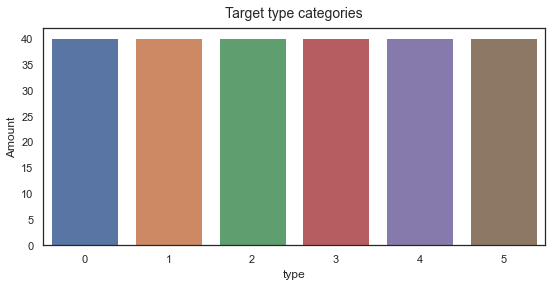


Target statistics:


,type
count,240.000000
mean,2.500000
std,1.711394
min,0.000000
25%,1.000000
50%,2.500000
75%,4.000000
max,5.000000


In [31]:
create_visualization(data=data, dtype="target", target="type",
                     is_cat_target=True, figsize=(9, 4))

## temperature

Visualization of quantitative features distribution:

Feature: temperature


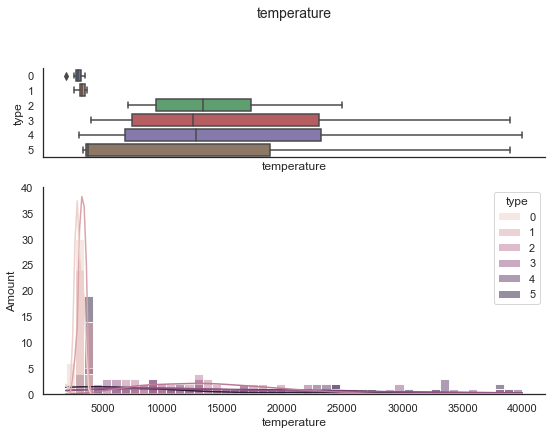


Feature statistics:


,temperature
count,240.00
mean,10497.46
std,9552.43
min,1939.00
25%,3344.25
50%,5776.00
75%,15055.50
max,40000.00


In [32]:
create_visualization(data=data[["temperature", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

### В разбивке по классам таргета

#### 0

---------- Temperature statistics for target class 0 ----------

Visualization of quantitative features distribution:

Feature: temperature


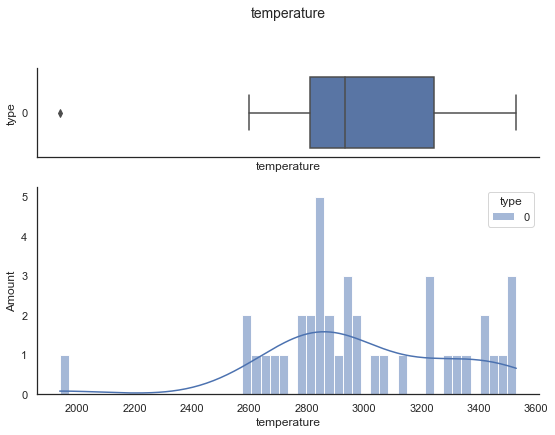


Feature statistics:


,temperature
count,40.00
mean,2997.95
std,332.28
min,1939.00
25%,2812.75
50%,2935.00
75%,3242.50
max,3531.00


In [106]:
visualize_feature_for_target_classes(data, "temperature", "type", 0)

#### 1

---------- Temperature statistics for target class 1 ----------

Visualization of quantitative features distribution:

Feature: temperature


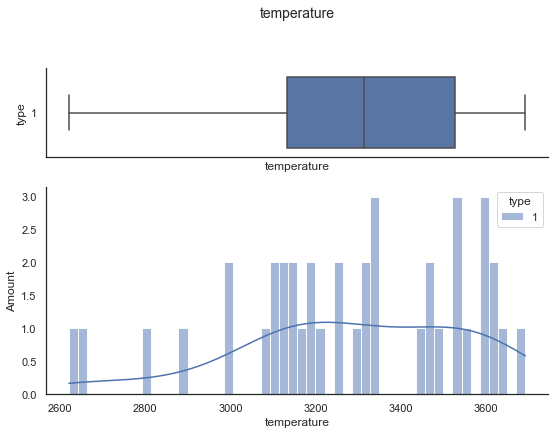


Feature statistics:


,temperature
count,40.00
mean,3283.82
std,269.64
min,2621.00
25%,3132.75
50%,3314.00
75%,3527.50
max,3692.00


In [107]:
visualize_feature_for_target_classes(data, "temperature", "type", 1)

#### 2

---------- Temperature statistics for target class 2 ----------

Visualization of quantitative features distribution:

Feature: temperature


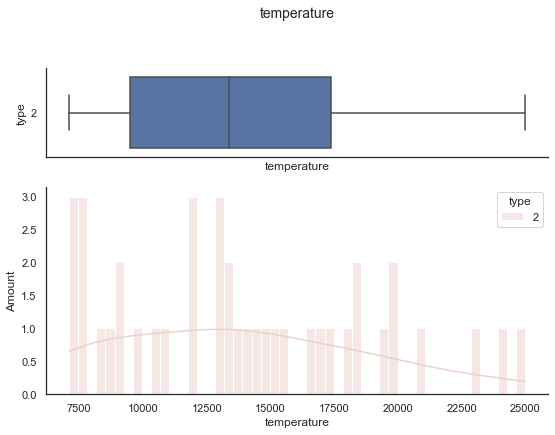


Feature statistics:


,temperature
count,40.00
mean,13931.45
std,4957.66
min,7100.00
25%,9488.75
50%,13380.00
75%,17380.00
max,25000.00


In [108]:
visualize_feature_for_target_classes(data, "temperature", "type", 2)

#### 3

---------- Temperature statistics for target class 3 ----------

Visualization of quantitative features distribution:

Feature: temperature


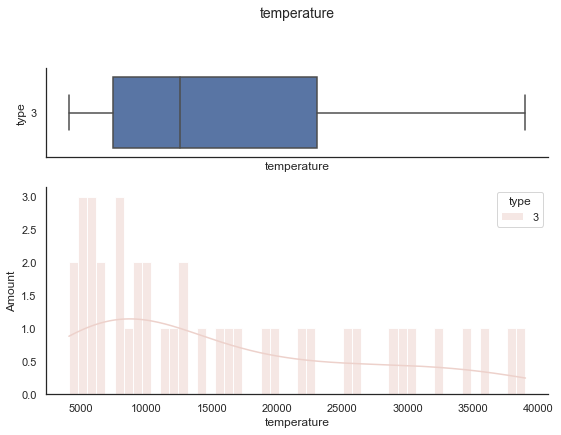


Feature statistics:


,temperature
count,40.00
mean,16018.00
std,10661.23
min,4077.00
25%,7479.25
50%,12560.50
75%,23030.00
max,39000.00


In [109]:
visualize_feature_for_target_classes(data, "temperature", "type", 3)

#### 4

---------- Temperature statistics for target class 4 ----------

Visualization of quantitative features distribution:

Feature: temperature


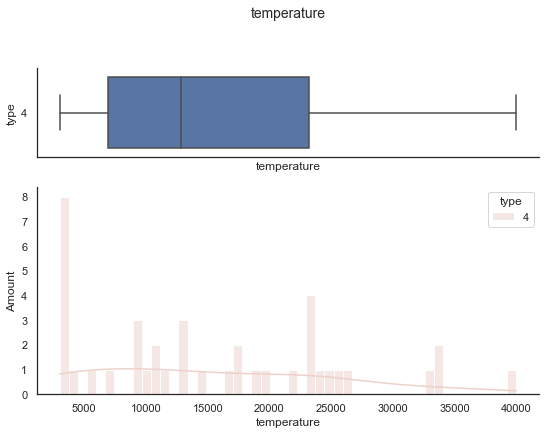


Feature statistics:


,temperature
count,40.00
mean,15347.85
std,10086.78
min,3008.00
25%,6899.50
50%,12821.00
75%,23181.25
max,40000.00


In [110]:
visualize_feature_for_target_classes(data, "temperature", "type", 4)

#### 5

---------- Temperature statistics for target class 5 ----------

Visualization of quantitative features distribution:

Feature: temperature


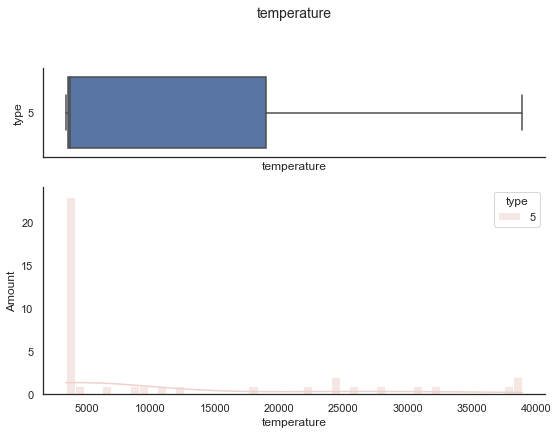


Feature statistics:


,temperature
count,40.00
mean,11405.70
std,11816.99
min,3399.00
25%,3603.75
50%,3766.00
75%,18976.00
max,38940.00


In [111]:
visualize_feature_for_target_classes(data, "temperature", "type", 5)

## luminosity

Visualization of quantitative features distribution:

Feature: luminosity


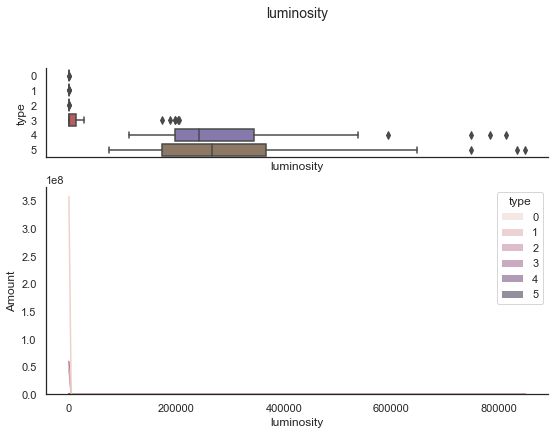


Feature statistics:


,luminosity
count,240.00
mean,107188.37
std,179432.19
min,0.00
25%,0.00
50%,0.07
75%,198050.00
max,849420.00


In [34]:
create_visualization(data=data[["luminosity", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

### В разбивке по классам таргета

#### 0

---------- Luminosity statistics for target class 0 ----------

Visualization of quantitative features distribution:

Feature: luminosity


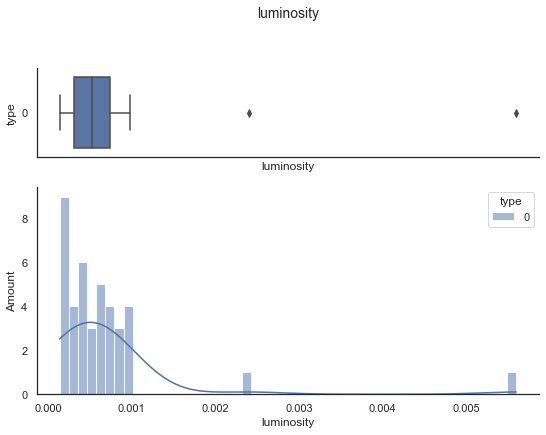


Feature statistics:


,luminosity
count,40.00
mean,0.00
std,0.00
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,0.01


In [118]:
visualize_feature_for_target_classes(data, "luminosity", "type", 0)

#### 1

---------- Luminosity statistics for target class 1 ----------

Visualization of quantitative features distribution:

Feature: luminosity


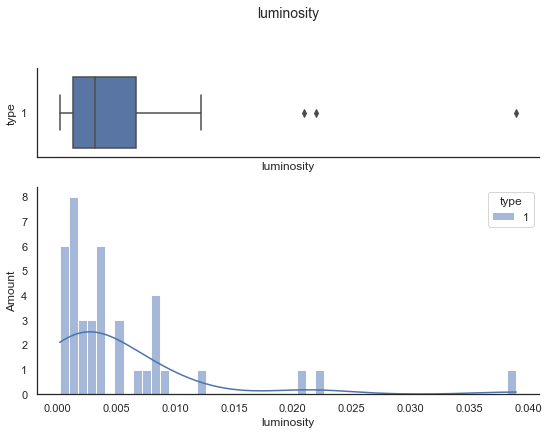


Feature statistics:


,luminosity
count,40.00
mean,0.01
std,0.01
min,0.00
25%,0.00
50%,0.00
75%,0.01
max,0.04


In [119]:
visualize_feature_for_target_classes(data, "luminosity", "type", 1)

#### 2

---------- Luminosity statistics for target class 2 ----------

Visualization of quantitative features distribution:

Feature: luminosity


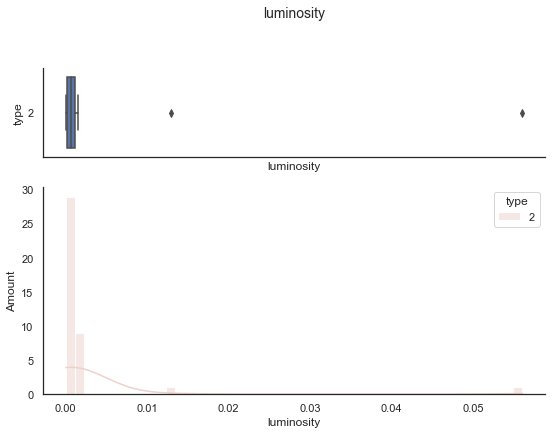


Feature statistics:


,luminosity
count,40.00
mean,0.00
std,0.01
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,0.06


In [120]:
visualize_feature_for_target_classes(data, "luminosity", "type", 2)

#### 3

---------- Luminosity statistics for target class 3 ----------

Visualization of quantitative features distribution:

Feature: luminosity


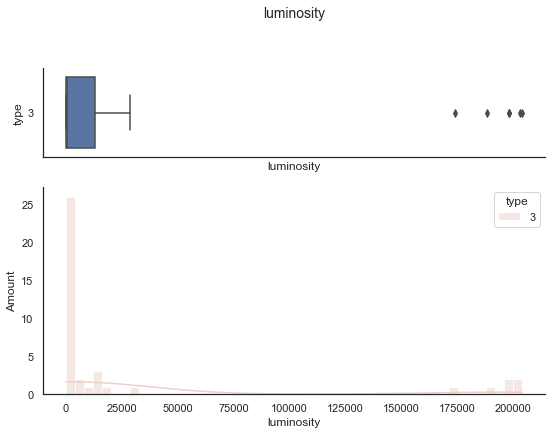


Feature statistics:


,luminosity
count,40.00
mean,32067.39
std,69351.20
min,0.09
25%,6.30
50%,738.50
75%,12962.50
max,204000.00


In [121]:
visualize_feature_for_target_classes(data, "luminosity", "type", 3)

#### 4

---------- Luminosity statistics for target class 4 ----------

Visualization of quantitative features distribution:

Feature: luminosity


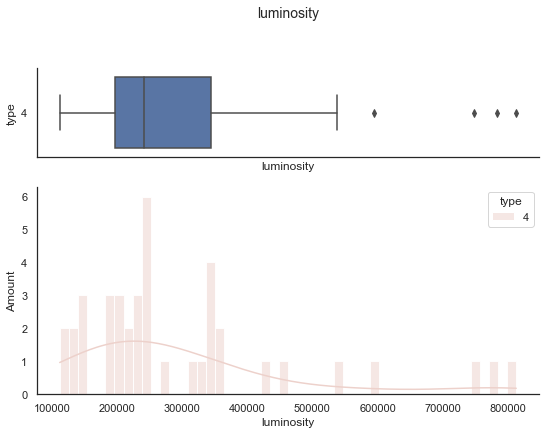


Feature statistics:


,luminosity
count,40.00
mean,301816.25
std,175756.38
min,112000.00
25%,197250.00
50%,242145.00
75%,344160.00
max,813000.00


In [122]:
visualize_feature_for_target_classes(data, "luminosity", "type", 4)

#### 5

---------- Luminosity statistics for target class 5 ----------

Visualization of quantitative features distribution:

Feature: luminosity


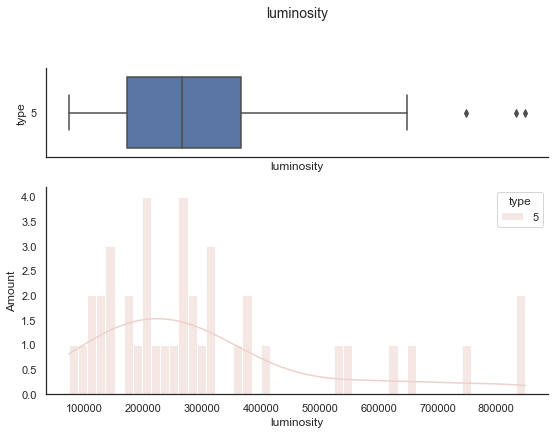


Feature statistics:


,luminosity
count,40.00
mean,309246.53
std,199344.00
min,74000.00
25%,173000.00
50%,266500.00
75%,365957.50
max,849420.00


In [123]:
visualize_feature_for_target_classes(data, "luminosity", "type", 5)

## radius

Visualization of quantitative features distribution:

Feature: radius


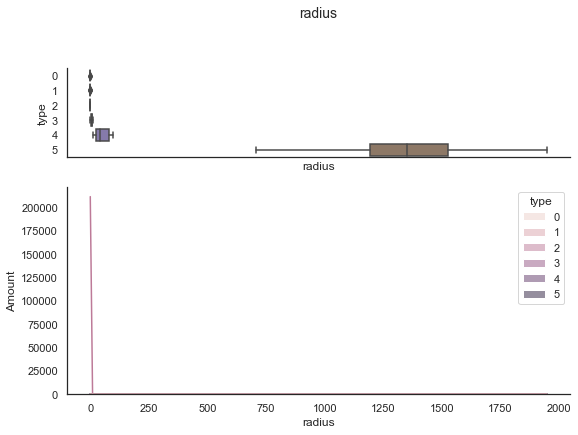


Feature statistics:


,radius
count,240.00
mean,237.25
std,inf
min,0.01
25%,0.10
50%,0.76
75%,42.75
max,1948.00


In [124]:
create_visualization(data=data[["radius", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

### В разбивке по классам таргета

#### 0

---------- Radius statistics for target class 0 ----------

Visualization of quantitative features distribution:

Feature: radius


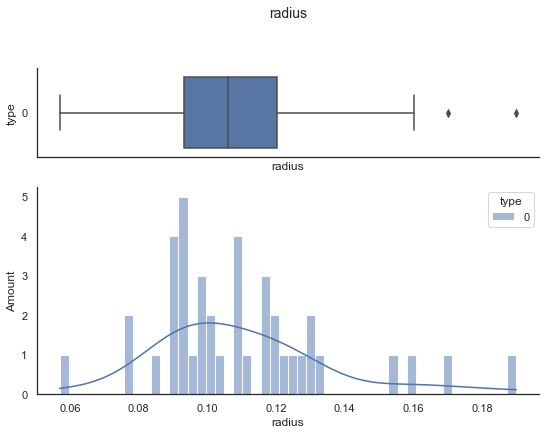


Feature statistics:


,radius
count,40.00
mean,0.11
std,0.03
min,0.06
25%,0.09
50%,0.11
75%,0.12
max,0.19


In [125]:
visualize_feature_for_target_classes(data, "radius", "type", 0)

#### 1

---------- Radius statistics for target class 1 ----------

Visualization of quantitative features distribution:

Feature: radius


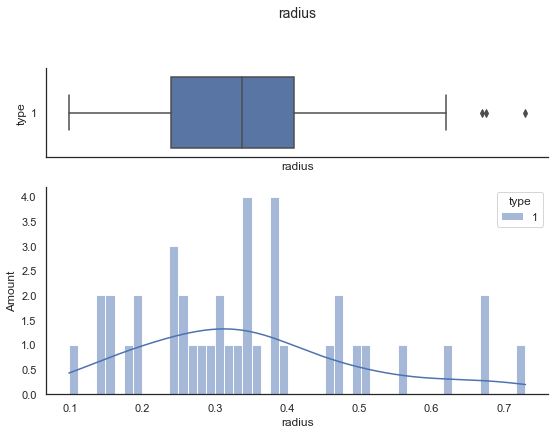


Feature statistics:


,radius
count,40.00
mean,0.35
std,0.15
min,0.10
25%,0.24
50%,0.34
75%,0.41
max,0.73


In [126]:
visualize_feature_for_target_classes(data, "radius", "type", 1)

#### 2

---------- Radius statistics for target class 2 ----------

Visualization of quantitative features distribution:

Feature: radius


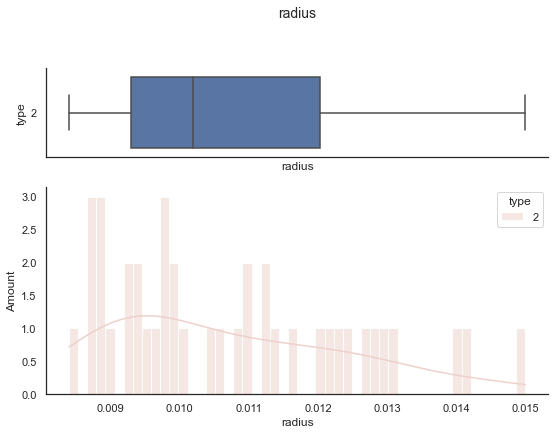


Feature statistics:


,radius
count,40.00
mean,0.01
std,0.00
min,0.01
25%,0.01
50%,0.01
75%,0.01
max,0.01


In [127]:
visualize_feature_for_target_classes(data, "radius", "type", 2)

#### 3

---------- Radius statistics for target class 3 ----------

Visualization of quantitative features distribution:

Feature: radius


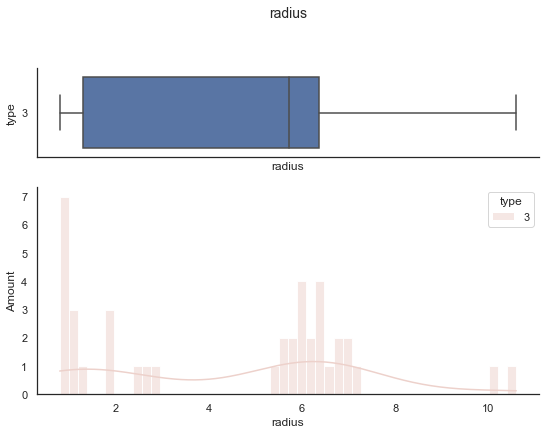


Feature statistics:


,radius
count,40.00
mean,4.43
std,2.80
min,0.79
25%,1.29
50%,5.71
75%,6.37
max,10.60


In [128]:
visualize_feature_for_target_classes(data, "radius", "type", 3)

#### 4

---------- Radius statistics for target class 4 ----------

Visualization of quantitative features distribution:

Feature: radius


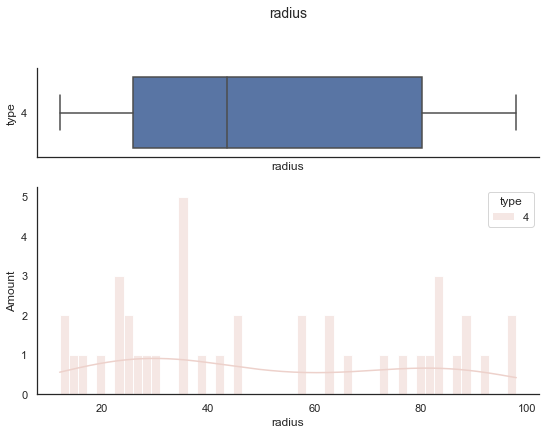


Feature statistics:


,radius
count,40.00
mean,51.16
std,27.66
min,12.00
25%,25.75
50%,43.50
75%,80.25
max,98.00


In [129]:
visualize_feature_for_target_classes(data, "radius", "type", 4)

#### 5

---------- Radius statistics for target class 5 ----------

Visualization of quantitative features distribution:

Feature: radius


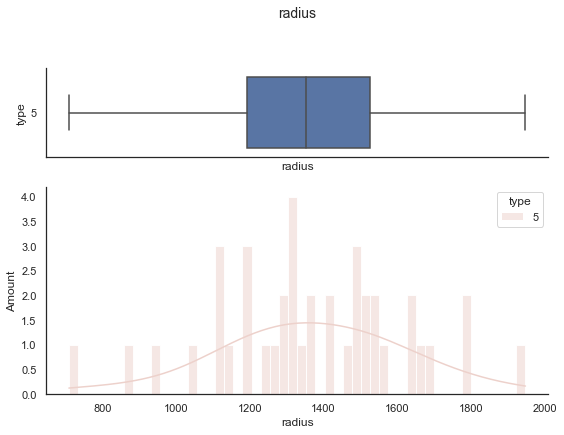


Feature statistics:


,radius
count,40.0
mean,1367.0
std,inf
min,709.0
25%,1193.0
50%,1352.5
75%,1525.0
max,1948.0


In [130]:
visualize_feature_for_target_classes(data, "radius", "type", 5)

## magnitude

Visualization of quantitative features distribution:

Feature: magnitude


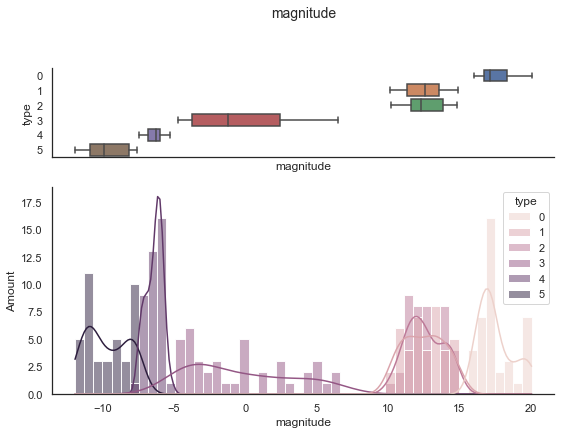


Feature statistics:


,magnitude
count,240.00
mean,4.38
std,10.53
min,-11.92
25%,-6.23
50%,8.31
75%,13.70
max,20.06


In [37]:
create_visualization(data=data[["magnitude", "type"]], dtype="scalars",
                     target="type", is_cat_target=True, figsize=(9, 6))

### В разбивке по классам таргета

#### 0

---------- Magnitude statistics for target class 0 ----------

Visualization of quantitative features distribution:

Feature: magnitude


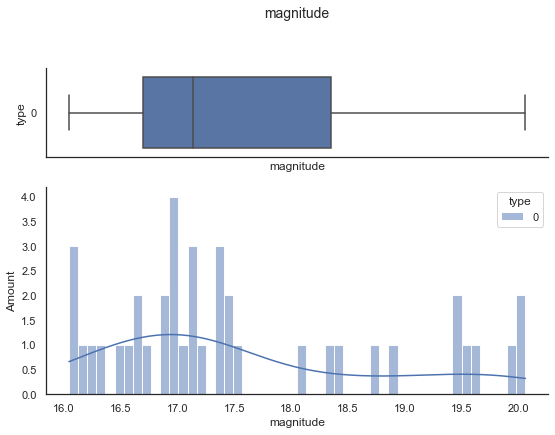


Feature statistics:


,magnitude
count,40.00
mean,17.56
std,1.21
min,16.05
25%,16.70
50%,17.14
75%,18.36
max,20.06


In [133]:
visualize_feature_for_target_classes(data, "magnitude", "type", 0)

#### 1

---------- Magnitude statistics for target class 1 ----------

Visualization of quantitative features distribution:

Feature: magnitude


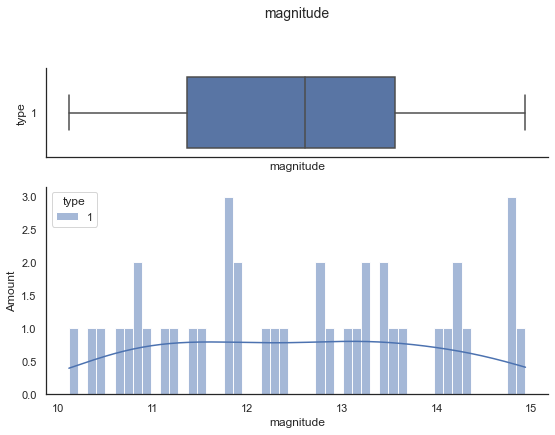


Feature statistics:


,magnitude
count,40.00
mean,12.54
std,1.42
min,10.12
25%,11.37
50%,12.61
75%,13.56
max,14.94


In [134]:
visualize_feature_for_target_classes(data, "magnitude", "type", 1)

#### 2

---------- Magnitude statistics for target class 2 ----------

Visualization of quantitative features distribution:

Feature: magnitude


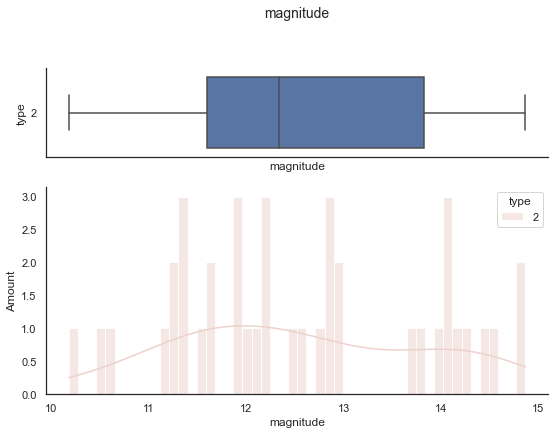


Feature statistics:


,magnitude
count,40.00
mean,12.58
std,1.28
min,10.18
25%,11.59
50%,12.34
75%,13.83
max,14.87


In [135]:
visualize_feature_for_target_classes(data, "magnitude", "type", 2)

#### 3

---------- Magnitude statistics for target class 3 ----------

Visualization of quantitative features distribution:

Feature: magnitude


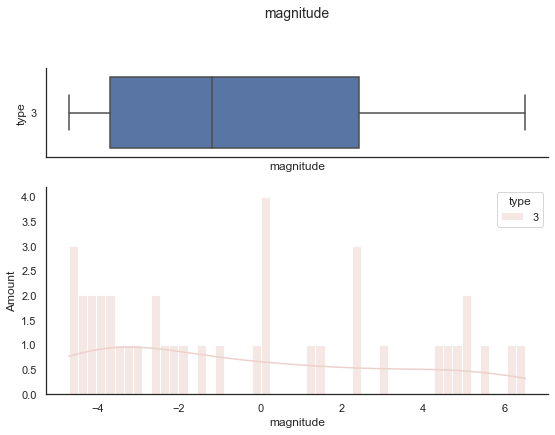


Feature statistics:


,magnitude
count,40.00
mean,-0.37
std,3.61
min,-4.70
25%,-3.70
50%,-1.18
75%,2.42
max,6.51


In [136]:
visualize_feature_for_target_classes(data, "magnitude", "type", 3)

#### 4

---------- Magnitude statistics for target class 4 ----------

Visualization of quantitative features distribution:

Feature: magnitude


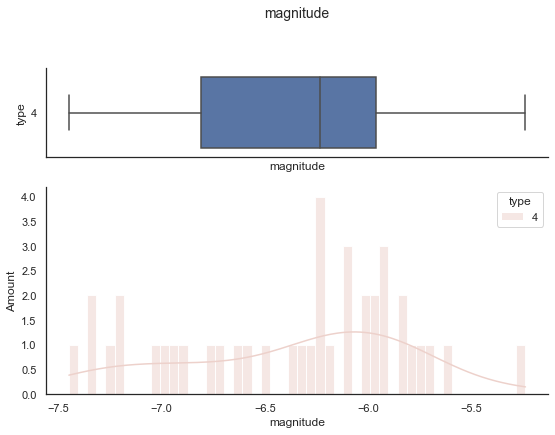


Feature statistics:


,magnitude
count,40.00
mean,-6.37
std,0.56
min,-7.45
25%,-6.81
50%,-6.23
75%,-5.96
max,-5.24


In [137]:
visualize_feature_for_target_classes(data, "magnitude", "type", 4)

#### 5

---------- Magnitude statistics for target class 5 ----------

Visualization of quantitative features distribution:

Feature: magnitude


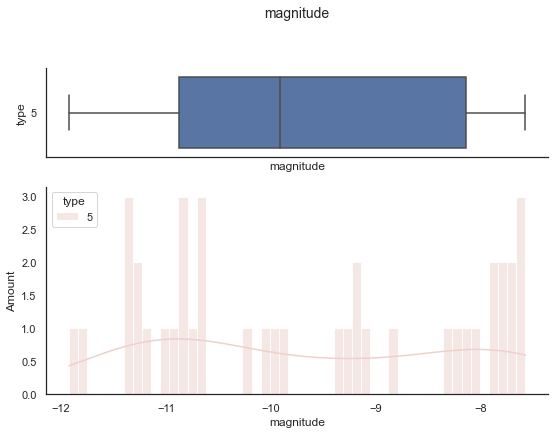


Feature statistics:


,magnitude
count,40.00
mean,-9.66
std,1.45
min,-11.92
25%,-10.88
50%,-9.91
75%,-8.15
max,-7.58


In [138]:
visualize_feature_for_target_classes(data, "magnitude", "type", 5)

## color

Visualization of categorical features and target prevalence:

Feature: color


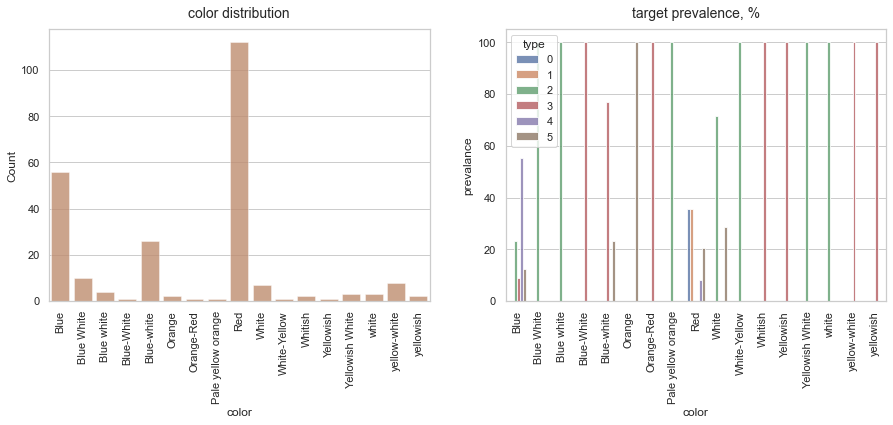

In [174]:
create_visualization(data=data[["color", "type"]], dtype="categories",
                     target="type", is_cat_target=True, figsize=(15, 5))

Visualization of categorical features and target prevalence:

Feature: color


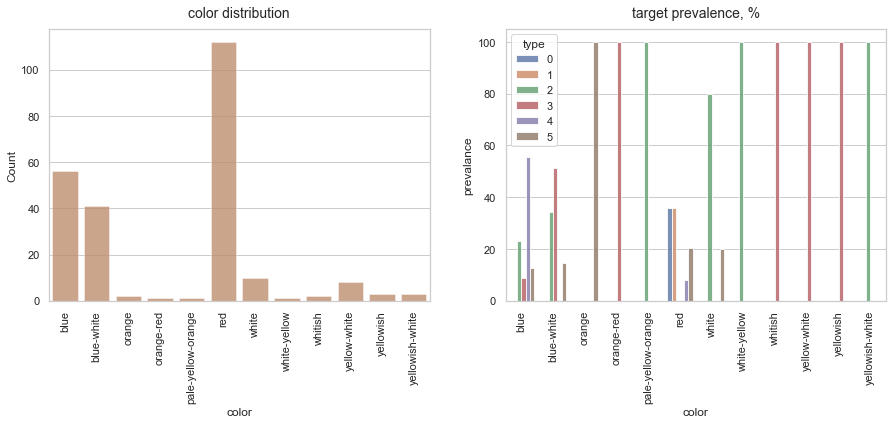

In [175]:
data["color"] = data["color"].apply(lambda x: x.lower().replace(" ", '-'))

create_visualization(data=data[["color", "type"]], dtype="categories",
                     target="type", is_cat_target=True, figsize=(15, 5))

In [202]:
colors = group_colors(data)

RED: 
 ['red', 'orange-red'] 

ORANGE: 
 ['pale-yellow-orange', 'orange'] 

BLUE: 
 ['blue-white', 'blue'] 

WHITE: 
 ['white', 'yellowish-white', 'yellow-white', 'white-yellow'] 

YELLOW: 
 ['yellowish'] 


-------------------------
UNMATCHED COLORS:
['whitish']


In [234]:
colors

{'reds': ['red', 'orange-red'],
 'oranges': ['pale-yellow-orange', 'orange'],
 'blues': ['blue-white', 'blue'],
 'whites': ['white', 'yellowish-white', 'yellow-white', 'white-yellow'],
 'yellows': ['yellowish'],
 'others': ['whitish']}

## по цветам

In [261]:
colors_stat = data["color"].value_counts(normalize=True)
colors_stat

red                   0.466667
blue                  0.233333
blue-white            0.170833
white                 0.041667
yellow-white          0.033333
yellowish-white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale-yellow-orange    0.004167
white-yellow          0.004167
orange-red            0.004167
Name: color, dtype: float64

### Красные

Visualization of categorical features and target prevalence:

Feature: color


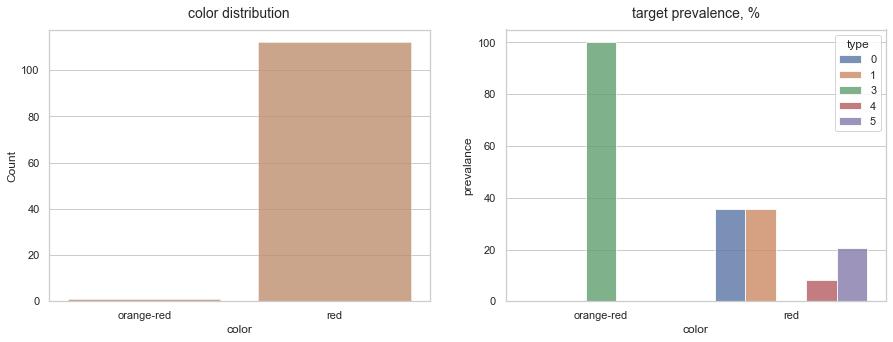

In [238]:
create_visualization(
    data=data[
        data["color"].isin(colors["reds"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

### Оранжевые

Visualization of categorical features and target prevalence:

Feature: color


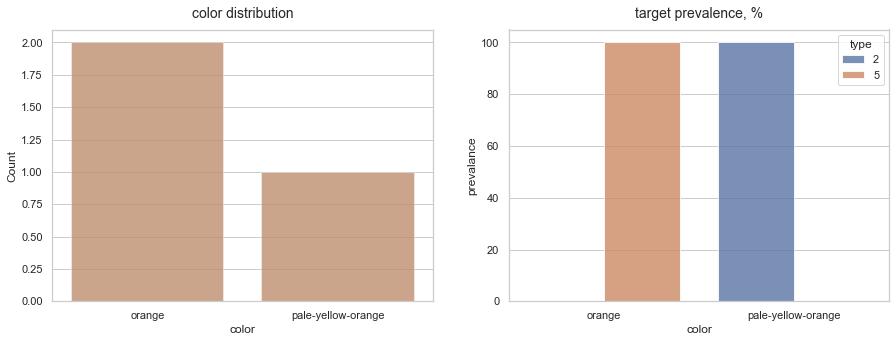

In [240]:
create_visualization(
    data=data[
        data["color"].isin(colors["oranges"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

### Синие

Visualization of categorical features and target prevalence:

Feature: color


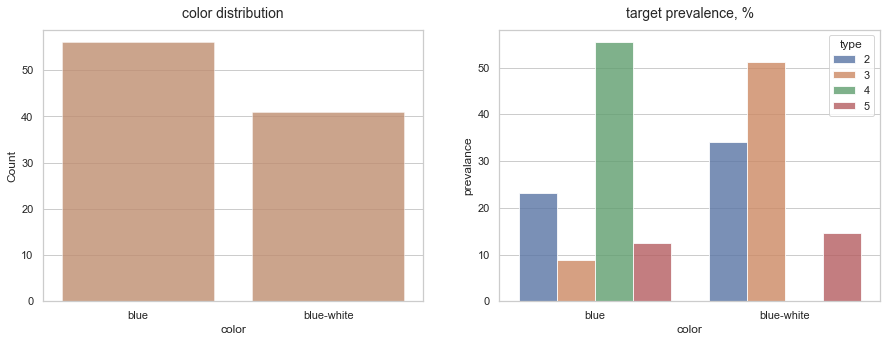

In [242]:
create_visualization(
    data=data[
        data["color"].isin(colors["blues"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

### Белые

Visualization of categorical features and target prevalence:

Feature: color


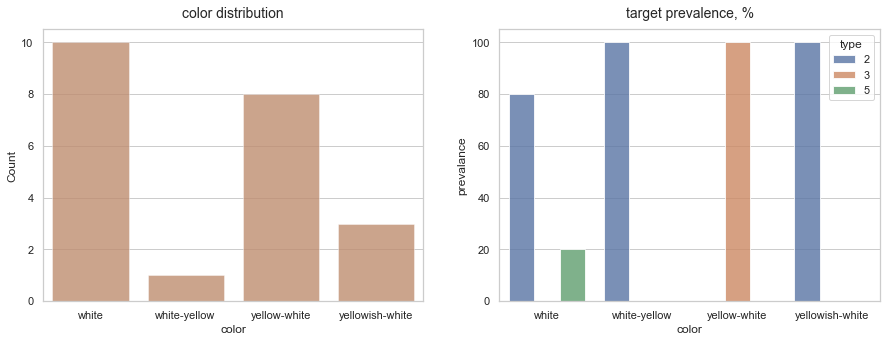

In [244]:
create_visualization(
    data=data[
        data["color"].isin(colors["whites"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

### Желтые

Visualization of categorical features and target prevalence:

Feature: color


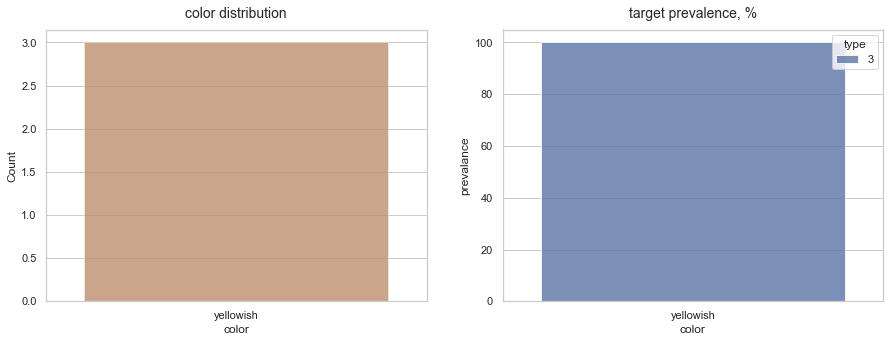

In [245]:
create_visualization(
    data=data[
        data["color"].isin(colors["yellows"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

### Прочие цвета

Visualization of categorical features and target prevalence:

Feature: color


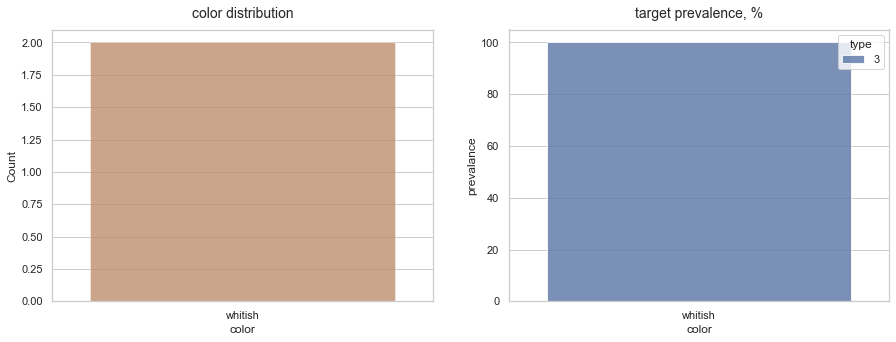

In [246]:
create_visualization(
    data=data[
        data["color"].isin(colors["others"])
        ][["color", "type"]],
    dtype="categories", target="type", is_cat_target=True, figsize=(15, 5))

## Обработка цветов

In [264]:
main_colors = list(colors_stat[colors_stat > 0.05].index)
main_colors

['red', 'blue', 'blue-white']

Visualization of categorical features and target prevalence:

Feature: color


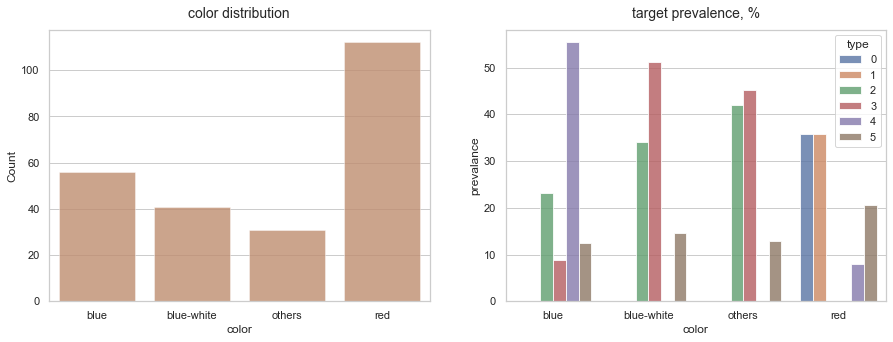

In [265]:
data["color"] = data["color"].apply(
    lambda x: x if x in main_colors else "others")

create_visualization(data=data[["color", "type"]], dtype="categories",
                     target="type", is_cat_target=True, figsize=(15, 5))

# НАДО ЕЩЁ: разбить на выборки, нормализовать и OHE и все

## Построение базовой нейронной сети

## Улучшение нейронной сети

## Выводы